# Analysis / Plotting - Notebook 06 - numagents
Author: Bettina Vignolo

This notebook was created to perform several smaller experiments with the microtubule model and analyze the results. It focuses on ```numagents``` and how this parameter influences MT length

In [1]:
# load Packages:
using Agents
using Statistics
using DataFrames
using Distributions
using StatsBase
using DrWatson: @dict
using Serialization
using InteractiveDynamics
using GLMakie
import ColorSchemes as co
using DataFramesMeta

# load Functions:
include("01_Agent.jl")
include("02_Initialization.jl")
include("03_AgentStep.jl")
include("04_ModelStep.jl")
include("05_Analysis.jl")

mean_velocity_cat (generic function with 1 method)

In [1]:
using Distributed
addprocs(8)

@everywhere begin
    # load Packages:
    using Agents
    using Statistics
    using DataFrames
    using Distributions
    using StatsBase
    using DrWatson: @dict
    using Serialization
    using InteractiveDynamics
    using GLMakie
    import ColorSchemes as co
    using DataFramesMeta

    # load Functions:
    include("01_Agent.jl")
    include("02_Initialization.jl")
    include("03_AgentStep.jl")
    include("04_ModelStep.jl")
    include("05_Analysis.jl")
end    

## 1. Scanning for ideal range


### 1.1 First try with 10 different numagents

In [2]:
parameters=Dict(
            :griddims => (100,100),
            :periodic => true,
            :Nstarts => 4,
            :numagents => collect([400:400:4000]...), 
            :p_hyd => 0.024,                
            :p_polym=> 1.0 ,    
            :p_depolym_GTP => 0.0,
            :p_depolym_GDP => 0.5, 
            :p_GTP_exchange => 0.01 )
# Model Data:
mdata = [mean_MT_size]
# Run Model 
_ , paramdata = paramscan(parameters, initialize; mdata, agent_step!, model_step!, n=10000)
serialize("data/paramscan_numagents_10kSteps.jls", paramdata)

Progress: 100%|█████████████████████████████████████████| Time: 0:11:36


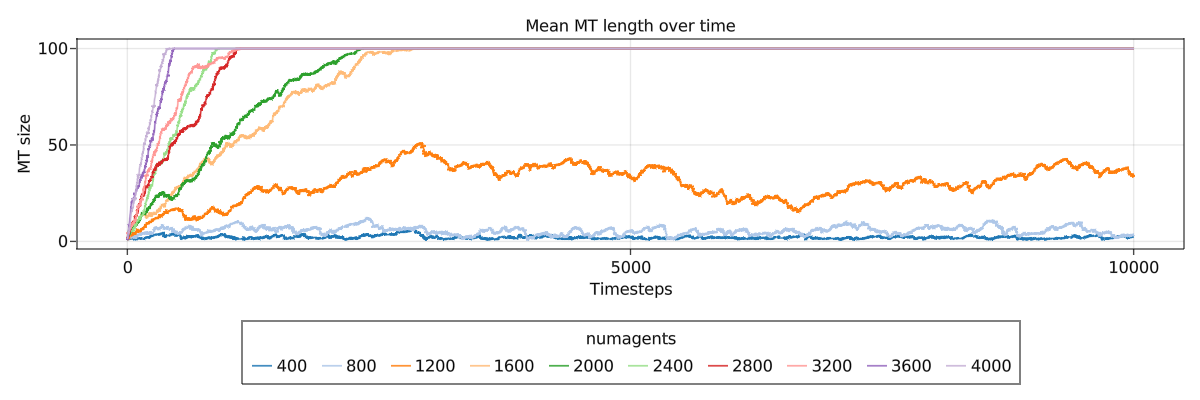

GLFWError (PLATFORM_ERROR): WGL: Failed to make context current: Das Handle ist ungültig. 
Stacktrace:
 [1] _ErrorCallbackWrapper(code::Int32, description::Cstring)
   @ GLFW C:\Users\helen\.julia\packages\GLFW\BWxfF\src\callback.jl:43
 [2] MakeContextCurrent
   @ C:\Users\helen\.julia\packages\GLFW\BWxfF\src\glfw3.jl:694 [inlined]
 [3] make_context_current
   @ C:\Users\helen\.julia\packages\GLMakie\TfSB1\src\drawing_primitives.jl:47 [inlined]
 [4] fps_renderloop(screen::GLMakie.Screen, framerate::Float64)
   @ GLMakie C:\Users\helen\.julia\packages\GLMakie\TfSB1\src\rendering.jl:26
 [5] renderloop(screen::GLMakie.Screen; framerate::Float64)
   @ GLMakie C:\Users\helen\.julia\packages\GLMakie\TfSB1\src\rendering.jl:48
 [6] renderloop(screen::GLMakie.Screen)
   @ GLMakie C:\Users\helen\.julia\packages\GLMakie\TfSB1\src\rendering.jl:41
 [7] (::GLMakie.var"#56#58"{GLMakie.Screen})()
   @ GLMakie .\task.jl:429


In [3]:
data1 = deserialize("data/paramscan_numagents_10kSteps.jls");
f1 = Figure(resolution =(1200, 400))
ax1 = Axis(f1[1,1]; xlabel = "Timesteps", ylabel = "MT size", title = "Mean MT length over time")
range = collect(400:400:4000)

for (i,v) in enumerate(range)
    sub_data = @subset(data1, :numagents .== v)
    lines!(ax1, sub_data.step, sub_data.mean_MT_size, label = "$v", color = co.tab20[i])
end


Legend(f1[2,1], ax1, "numagents", orientation = :horizontal, tellwidth = false, tellheight = true)

f1

### 1.2 different numagents 400:200:2000

In [6]:
parameters=Dict(
            :griddims => (100,100),
            :periodic => true,
            :Nstarts => 4,
            :numagents => collect([400:200:2000]...), 
            :p_hyd => 0.024,                
            :p_polym=> 1.0 ,    
            :p_depolym_GTP => 0.0,
            :p_depolym_GDP => 0.5, 
            :p_GTP_exchange => 0.01 )
# Model Data:
mdata = [mean_MT_size]
# Run Model 
_ , paramdata = paramscan(parameters, initialize; mdata, agent_step!, model_step!, n=10000)
serialize("data/paramscan_numagents_till2000_10kSteps.jls", paramdata)

Progress: 100%|█████████████████████████████████████████| Time: 0:01:54


In [12]:
data1_2 = deserialize("data/paramscan_numagents_till2000_10kSteps.jls");
f1_2 = Figure(resolution =(1200, 400))
ax1_2 = Axis(f1_2[1,1]; xlabel = "Timesteps", ylabel = "MT size", title = "Mean MT length over time")
range = collect(400:200:2000)

for (i,v) in enumerate(range)
    sub_data = @subset(data1_2, :numagents .== v)
    lines!(ax1_2, sub_data.step, sub_data.mean_MT_size, label = "$v", color = co.tab20[i])
end


Legend(f1_2[2,1], ax1_2, "numagents", orientation = :horizontal, tellwidth = false, tellheight = true)

f1_2

### 1.3 10 Ensemble + 100k steps
runtime 53min

In [13]:
@everywhere begin
models = [initialize(;
        Nstarts = 4,
        periodic = true,
        numagents = x,
        griddims = (100,100), 
        p_polym = 1.0,
        p_hyd = 0.024,
        p_GTP_exchange = 0.01,
        p_depolym_GTP = 0.0,
        p_depolym_GDP = 0.5)  
    for x in repeat(collect([400:200:1600]...), 10)]

mdata = [mean_MT_size, (:numagents)]
mlabels = ["mean MT length", "numagents"]
end

data_ens = ensemblerun!(models, agent_step!, model_step!, 100000; mdata, parallel = true)
serialize("data/paramscan_numagents_10ensemble_100kSteps.jls", data_ens[2])

In [25]:
data1_6 = deserialize("data/paramscan_numagents_10ensemble_100kSteps.jls")
gdf = groupby(@subset(data1_6, :ensemble .!= 14), [:step, :numagents]) #
sum_1_6 = combine(gdf, [:mean_MT_size] .=> [mean]);

In [31]:
#MT length over time
f1_6 = Figure(resolution =(1200, 600))
ax1_6 = Axis(f1_6[1,1]; xlabel = "Timesteps", ylabel = "MT size", title = "Mean MT length over time (10x ensemble) - excluded ensemble 14")
range = collect(400:200:1600)

for (i,v) in enumerate(range)
    sub_data = @subset(sum_1_6, :numagents .== v)
    lines!(ax1_6, sub_data.step, sub_data.mean_MT_size_mean, label = "$v", color = co.tab20[i])
end


Legend(f1_6[2,1], ax1_6, "numagents", orientation = :horizontal, tellwidth = false, tellheight = true)

f1_6

In [30]:
@subset(data1_6, :numagents .== 1600, :step .== 50000) # exclude ensemble 14

,step,mean_MT_size,numagents,ensemble
,Int64,Float64,Int64,Int64
1,50000,100.0,1600,7
2,50000,75.0,1600,14
3,50000,100.0,1600,21
4,50000,100.0,1600,28
5,50000,100.0,1600,35
6,50000,100.0,1600,42
7,50000,79.75,1600,49
8,50000,100.0,1600,56
9,50000,100.0,1600,63


In [32]:
#Mean Length
f2_6 = Figure(resolution = (800, 600)) 
range = collect(400:200:1600)

ax2_6 = Axis(f2_6[1,1]; titel = "Avg of MT lengths", xlabel = "numagents", ylabel ="Mean MT length", xticks = LinearTicks(7), yticklabelcolor = :green,  ylabelcolor = :green)

means = Float64[]
stds = Float64[]
for (i,v) in enumerate(range)
    df_sub = @subset(sum_1_6, :step .>= 50000, :numagents .== v)  
    append!(means, mean(df_sub.mean_MT_size_mean))
    append!(stds, std(df_sub.mean_MT_size_mean))
end

l1 = lines!(ax2_6, range, means, color = :green)
l2 = errorbars!(ax2_6, range, means, stds, color = :red, whiskerwidth = 10)

Legend(f2_6[2,1], [l1, l2], ["Mean", "Std"], orientation = :horizontal, tellwidth = false, tellheight = true)

f2_6

### 1.4 10 Ensemble + 100k steps different range
runtime 80min

In [2]:
@everywhere begin
models = [initialize(;
        Nstarts = 4,
        periodic = true,
        numagents = x,
        griddims = (100,100), 
        p_polym = 1.0,
        p_hyd = 0.024,
        p_GTP_exchange = 0.01,
        p_depolym_GTP = 0.0,
        p_depolym_GDP = 0.5)  
    for x in repeat(collect([400:150:1750]...), 10)]
mdata = [mean_MT_size, (:numagents)]
end

data_ens = ensemblerun!(models, agent_step!, model_step!, 100000; mdata, parallel = true)
serialize("data/paramscan_numagents_10ensemble_100kSteps_other_range.jls", data_ens[2])